## WCF Modelling

This code:

- Import a CSV and create a random forest model
- Choose a location and download some satellite data
- Apply model to satellite image
- Do some plotting

#### Questions and things to do

- Why is the data in the geomedian orders larger than the data in the csv?
    - I think the geomedian is in DNs and the training data is SR?
- What is the threshold for woody / not woody?
    - If it measures how woody, everything over 0 is woody?
- Fiddle with the random forest parameters
- Should I transform the inputs to be gaussian?

#### Other things to consider

- WCF saturates above 0.6

#### Sources of error

- Since WCF is derived from single-date LiDAR data and an annual geomedian is being used to predict it the geomedian may not represent the same vegetation as was present when LiDAR was acquired.
- Mixed pixels containing water and vegetation tended to overestimate WCF.
- Vegetation lower than 2m (e.g. dense shrubland or new plantations) could have a WCF from Landsat, although LiDAR would not have.

LiDAR
- Variation in pulse density (4 to 8 ppm)
- Variation in achieved density returns (4 to 20 ppm)

WCF derived from LiDAR was suprisingly low
- possibly due to attribution of VCF to height, and only above 2m is considered in WCF
- identifying points in LiDAR waveform is more challenging over dense uniform forest

Overall systematic underestimation of true cover at high values



#### Import modules

In [1]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from datacube.helpers import write_geotiff
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import xarray as xr
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
dc = datacube.Datacube(app='Alberts Forest')

#### Import training data csv

In [3]:
path = 'WCF_traindata_14122019.csv'
df = pd.read_csv(path)
df.head()

,WCF,blue,green,red,nir,swir1,swir2
0,0.680150,0.024840,0.038088,0.041936,0.20717,0.11010,0.062355
1,0.408790,0.043154,0.063489,0.069489,0.22708,0.17888,0.115670
2,0.000004,0.034636,0.064774,0.063311,0.32425,0.21022,0.111040
3,0.216960,0.032932,0.046541,0.050958,0.18029,0.17601,0.108140
4,0.434480,0.030078,0.046560,0.047636,0.20356,0.12678,0.073669


#### Plot training data bands

(array([3.6500e+02, 3.5900e+03, 1.0193e+04, 4.4710e+03, 3.0120e+03,
        3.2690e+03, 2.4770e+03, 2.5370e+03, 2.2850e+03, 2.1010e+03,
        1.8160e+03, 1.5520e+03, 1.5340e+03, 8.4900e+02, 3.1400e+02,
        1.2200e+02, 9.6000e+01, 7.7000e+01, 4.9000e+01, 5.5000e+01,
        4.0000e+01, 2.9000e+01, 3.3000e+01, 1.8000e+01, 1.2000e+01,
        1.9000e+01, 1.1000e+01, 3.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([-0.00074808,  0.01537486,  0.03149779,  0.04762073,  0.06374366,
         0.0798666 ,  0.09598954,  0.11211247,  0.12823541,  0.14435834,
         0.16048128,  0.17660422,  0.19272715,  0.20885009,  0.22497302,
         0.24109596,  0.2572189 ,  0.27334183,  0.28946477,  0.3055877 ,
         0.32171064,  0.33783358,  0.35395651,  0.37007945,  0.38620238,
         0.40232532,  0.41844826,  0.43457119,  0.45069413,  0.46681706,
         0.48294   ]),
 <a list of 30 Patch objects>)

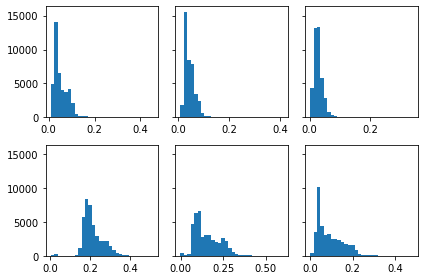

In [4]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
axs[0,0].hist(df[' red'],bins=30)
axs[0,1].hist(df[' green'],bins=30)
axs[0,2].hist(df['blue'],bins=30)
axs[1,0].hist(df[' nir'],bins=30)
axs[1,1].hist(df[' swir1'],bins=30)
axs[1,2].hist(df[' swir2'],bins=30)

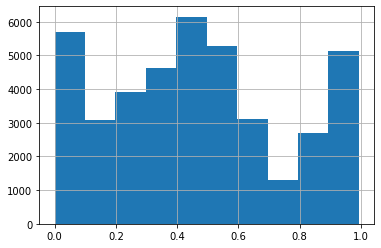

In [5]:
# Plot a histogram of WCF values
df['WCF'].hist()

#### Create and evaluate model

https://www.youtube.com/watch?v=YYjvkSJoui4 

Training data formatting

In [6]:
# Handle misisng data
df = df.dropna()

# Define dependent variable
Y = df['WCF']

# Define independent variables
X = df.drop(labels=['WCF'],axis=1)

# Split model into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

Make a model

In [7]:
# Define model
model = RandomForestRegressor(n_estimators=100, # number of trees in forest, is this equal to ensemble?
                              #criterion = 'mse', # function to measure the quality of the split
                              #max_depth = None, # max depth of tree. If None, then nodes are expanded until all laves are pure, or until all leaves contain less than min_samples_split
                              min_samples_split = 2, # Min no. samples required to be at a split node 
                              min_samples_leaf = 50, # Min no. samples required to be at a leaf node 
                              #min_weight_fraction_leaf = 0, # The min weighted fraction. Samples have equal weight when 0.
                              #max_features = 'auto', # The number of features to consider when looking for the best split
                              #max_leaf_nodes = None, # If None, then unlimited number of leaf nodes
                              #min_impurity_decrease = 0, # Split nodes to decrease impurity
                              #min_impurity_split = 1e-7, # Replaced by min_impurity_decrease
                              #bootstrap = true, # Whether to bootstrap samples when building trees. If False, the whole dataset is used ot build each tree.
                              #oob_score = False, # Whether to use out-of-bag samples to estimate R^2 on unseen data
                              #n_jobs = None, # The number of jobs to run in parallel. None means 1
                              random_state=30, # Controls the randomness of bootstrapping and the sampling of features to consider for bets node split
                              #verbose = 0, # Controls the verbosity when fititng and predicting
                              #warm_start = False, # False - fit new forest, True - reuse solution from previous call amd add more estimators to ensemble
                              #ccp_alpha = 0.0, # Complexity parameter
                              #max_samples = None, # If bootstrap is True, the numbe rof samples to draw from X to train each base estimator
                             )

# Fit model
model.fit(X_train,Y_train)

# Predict test data
prediction_test = model.predict(X_test)

In [8]:
X_train.head()

,blue,green,red,nir,swir1,swir2
15659,0.029332,0.044725,0.051168,0.18150,0.154330,0.094460
15644,0.041128,0.078211,0.076077,0.37090,0.268270,0.160590
20255,0.032936,0.058935,0.098673,0.16574,0.217840,0.185850
39841,0.025500,0.030995,0.029067,0.17310,0.099446,0.045347
7415,0.027389,0.043515,0.045561,0.20521,0.157140,0.086316


In [9]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

#### Performance metrics

In draft:
- Root mean square estimate (RMSE) = 0.061
- Coefficient of determination (R^2) = 0.862
- Nash-Sutcliffe model efficiency (ME) = 0.862

In [10]:
# Metrics
print('Explained variance score = ')
print(metrics.explained_variance_score(Y_test, prediction_test)) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html
print('R^2 =')
print(metrics.r2_score(Y_test, prediction_test))
print('RMSE =')
print(metrics.mean_squared_error(Y_test, prediction_test))

Explained variance score = 
0.9246561500356675
R^2 =
0.9246331026823922
RMSE =
0.0062849142408366344


In [11]:
Y_test

29707    0.438090
26116    0.021492
14440    0.488280
15239    0.516790
11768    0.000137
           ...   
31124    0.469540
37764    0.412260
36463    0.915140
34325    0.921150
28606    0.456580
Name: WCF, Length: 8188, dtype: float64

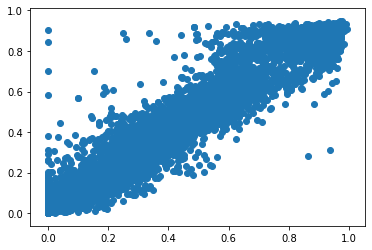

In [12]:
plt.scatter(Y_test, prediction_test)

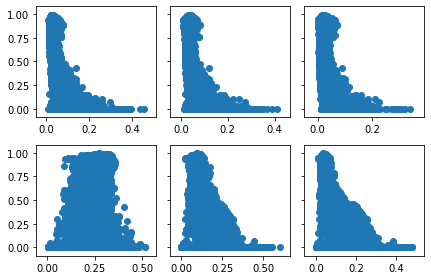

In [13]:
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
axs[0,0].scatter(df[' red'],df['WCF'])
axs[0,1].scatter(df[' green'],df['WCF'])
axs[0,2].scatter(df['blue'],df['WCF'])
axs[1,0].scatter(df[' nir'],df['WCF'])
axs[1,1].scatter(df[' swir1'],df['WCF'])
axs[1,2].scatter(df[' swir2'],df['WCF'])

#### Order of importance



nir, blue, swir1, green, swir2, red

In [14]:
# Determine the importance of each of the bands
#print(model.feature_importances_) # need to format nicely
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

 swir1    0.659130
 nir      0.155018
 green    0.090847
 swir2    0.060815
blue      0.021226
 red      0.012964
dtype: float64


## Hyperparameter tuning with:
1. Randomized Search CV
2. Grid Search CV

In [ ]:
# Create a blank model
model_cv = RandomForestRegressor(n_jobs=-1, verbose=0)

# View the hyperparameters
print(model_cv.get_params())

## Explore parameter tuning with Randomized Search CV

#### Set up the grid for use in the randomised search

In [ ]:
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# max_leaf_nodes = [20, 25, 30, 35, 40]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

Variables to use in the grid:

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 300, num = 20)]

# Minimum number of samples required at each leaf
min_samples_leaf = [1, 10, 30, 50, 75, 100]

# Random state
random_state = [None, 0, 10, 20, 30]

Create the grid:

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               #'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'random_state':random_state
               #'bootstrap': bootstrap
              }
print(random_grid)

#### Run the randomised search

This may take a while... 
(20 takes about 8 minutes)

In [ ]:
rscv_model = RandomizedSearchCV(estimator = model_cv, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rscv_results = rscv_model.fit(X_train, Y_train)

#### See the relative importance of variables

In [ ]:
model_variables = ['blue', ' green', ' red', ' nir', ' swir1', ' swir2']

# Variable importance
for var_name, var_importance in zip(model_variables, rscv_results.best_estimator_.feature_importances_):
    print("{}: {:.04}".format(var_name, var_importance))

#### From the randomised search find the best parameter values to use

In [ ]:
# Print best parameter values
rscv_results.best_estimator_

#### Create an improved model using the best parameter values
Copy best_estimator_ parameters into the code below

In [6]:
# Create an instance of the model
improved_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=28, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=163, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Fit the model
improved_model.fit(X_train,Y_train)

# Predict Y from X_test
pt = improved_model.predict(X_test)

# Print the R2
metrics.r2_score(Y_test,pt)

0.9409411699630139

## Detailed parameter tuning with Grid Search CV

#### Set up the grid for use in the grid search

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'min_samples_leaf': [1, 30, 60],
    'random_state':[None,0,30]
}

#### Run the grid search

This may take a while... 
(37 tasks takes about 5.5 minutes)

In [ ]:
grid_model = GridSearchCV(estimator = model_cv, param_grid = param_grid, cv = 3, verbose=2, n_jobs = -1)
grid_results = grid_model.fit(X_train, Y_train)

#### From the randomised search find the best parameter values to use

In [ ]:
print(grid_results.best_estimator_)

#### Create an improved model using the best parameter values
Copy best_estimator_ parameters into the code below

In [5]:
# Create an instance of the model
improved_grid_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# Fit the model
improved_grid_model.fit(X_train,Y_train)

# Predict Y from X_test
grid_pt = improved_grid_model.predict(X_test)

# Print the R2
metrics.r2_score(Y_test,grid_pt)

0.942185296731008

#### Do some pickling

In [16]:
# Pickle this model
pickle_out = open('pickled.pickle','wb')
pickle.dump(model,pickle_out)
pickle_out.close()

In [11]:
# pickle_in = open('pickled.pickle','rb')
# improved_grid_model = pickle.load(pickle_in)
# print(improved_grid_model)

## Apply the model to an image

In [225]:
# Create an instance of the model
improved_grid_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=50,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

# Fit the model
improved_grid_model.fit(X_train,Y_train)

# Predict Y from X_test
grid_pt = improved_grid_model.predict(X_test)

# Print the R2
metrics.r2_score(Y_test,grid_pt)

0.9246455248613923

### Choose location

When models were made for individual locations the performance varied significantly in Albert's data:

- Whroo in Victoria have an R^2 of only 0.35 (-36.703137, 145.035462)
- ACT had an R^2 of 0.87 (-35.434967, 149.002428)

Use custom area of interest:

In [18]:
# location = 'Canberra'

# # Set the central latitude and longitude
# central_lat = -35.434967
# central_lon = 149.002428

# # Set the buffer to load around the central coordinates
# buffer = 0.1

# # Compute the bounding box for the study area
# study_area_lat = (central_lat - buffer, central_lat + buffer)
# study_area_lon = (central_lon - buffer, central_lon + buffer)

# display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

Use LCCS test areas:

In [19]:
# Make sure to change the location for in the save file

location = 'Gwydir'
x = (1600000, 1700000)
y = (-3400000, -3300000)
min_x = 1600000
max_x = 1700000
min_y = -3400000
max_y = -3300000
res_x = 100
res_y = -100

# Display an interactive map
display_map(x=x, y=y, crs='EPSG:3577', margin=-0.1) 

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


### Load in image collection

In [20]:
start_date = '2010'
end_date = '2015' 

#Load all data in baseline period available from Near Real Time data

i_col = dc.load(
              product=['ls8_nbart_geomedian_annual', 'ls5_nbart_geomedian_annual'],
              x=x, #study_area_lon or x
              y=y, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              crs='EPSG:3577',
              resolution=(res_x,res_y)
              #resolution=(-50, 50),
              #group_by='solar_day'
)

Select images

<xarray.Dataset>
Dimensions:  (time: 1, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
  * y        (y) float64 -3.4e+06 -3.4e+06 -3.4e+06 ... -3.3e+06 -3.3e+06
  * x        (x) float64 1.7e+06 1.7e+06 1.7e+06 ... 1.6e+06 1.6e+06 1.6e+06
Data variables:
    blue     (time, y, x) int16 315 281 304 311 317 332 ... 754 760 756 730 747
    green    (time, y, x) int16 506 464 504 514 521 ... 1058 1060 1054 1024 1044
    red      (time, y, x) int16 539 464 535 559 561 ... 1198 1203 1198 1171 1188
    nir      (time, y, x) int16 1672 1603 1698 1794 1709 ... 1917 1857 1848 1926
    swir1    (time, y, x) int16 1938 1711 1883 1954 1951 ... 2723 2634 2678 2696
    swir2    (time, y, x) int16 1137 968 1095 1114 1135 ... 2186 2111 2144 2139
Attributes:
    crs:      EPSG:3577
<xarray.Dataset>
Dimensions:  (time: 1, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 -3.4e+06 -3.4e+06 -3.4e+06 ... -3.3e+06 -3.3e+06
  * x

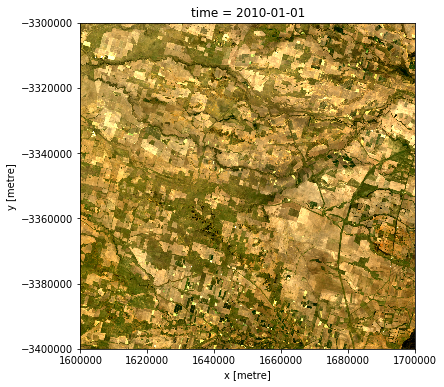

In [21]:
i_2010 = i_col.sel(time='2010')
i_2015 = i_col.sel(time='2015')
print(i_2010)
print(i_2015)
rgb(i_2010, bands=['red','green','blue'])

### Predict WCF on image

Define a function to format image and run model over it

In [22]:
def predict_wcf(image,model):
    flat = sklearn_flatten(image)
    flat = flat/10000
    results = model.predict(flat)
    unflat = (sklearn_unflatten(results,image).transpose())[0]
    return unflat

In [53]:
wcf_2010 = predict_wcf(i_2010,model)
wcf_2015 = predict_wcf(i_2015,model)

In [57]:
before_im.assign_coords({'time': 1})

<xarray.Dataset>
Dimensions:      (x: 695, y: 815)
Coordinates:
  * x            (x) float64 1.592e+06 1.592e+06 ... 1.612e+06 1.612e+06
  * y            (y) float64 -4.114e+06 -4.114e+06 ... -4.138e+06 -4.138e+06
    time         int64 1
Data variables:
    nbar_blue    (y, x) float32 329.0 358.0 364.0 315.0 ... 598.0 598.0 600.0
    nbar_green   (y, x) float32 600.0 678.0 688.0 497.0 ... 428.0 434.0 435.0
    nbar_red     (y, x) float32 474.0 514.0 503.0 414.0 ... 369.0 377.0 379.0
    nbar_nir     (y, x) float32 2799.0 3098.0 3611.0 ... 375.0 382.0 379.0
    nbar_swir_1  (y, x) float32 2112.0 2322.0 2210.0 ... 300.0 313.0 307.0
    nbar_swir_2  (y, x) float32 949.0 1130.0 994.0 785.0 ... 257.0 266.0 261.0
Attributes:
    crs:      EPSG:3577

In [56]:
i_2010

<xarray.Dataset>
Dimensions:  (time: 1, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
  * y        (y) float64 -3.4e+06 -3.4e+06 -3.4e+06 ... -3.3e+06 -3.3e+06
  * x        (x) float64 1.7e+06 1.7e+06 1.7e+06 ... 1.6e+06 1.6e+06 1.6e+06
Data variables:
    blue     (time, y, x) int16 315 281 304 311 317 332 ... 754 760 756 730 747
    green    (time, y, x) int16 506 464 504 514 521 ... 1058 1060 1054 1024 1044
    red      (time, y, x) int16 539 464 535 559 561 ... 1198 1203 1198 1171 1188
    nir      (time, y, x) int16 1672 1603 1698 1794 1709 ... 1917 1857 1848 1926
    swir1    (time, y, x) int16 1938 1711 1883 1954 1951 ... 2723 2634 2678 2696
    swir2    (time, y, x) int16 1137 968 1095 1114 1135 ... 2186 2111 2144 2139
Attributes:
    crs:      EPSG:3577

In [54]:
wcf_2010

<xarray.DataArray (y: 1000, x: 1000)>
array([[0.22841299, 0.34947669, 0.23233755, ..., 0.07547914, 0.07384692,
        0.0708187 ],
       [0.22411269, 0.33643618, 0.24068379, ..., 0.07547914, 0.06476262,
        0.07364779],
       [0.29285388, 0.35826585, 0.34905782, ..., 0.05183266, 0.0507086 ,
        0.06299425],
       ...,
       [0.03144238, 0.04971827, 0.04395415, ..., 0.0795433 , 0.07011113,
        0.06212424],
       [0.00573969, 0.01427991, 0.03380783, ..., 0.04327215, 0.0610182 ,
        0.04527124],
       [0.01375501, 0.01662332, 0.00905961, ..., 0.04439725, 0.03962697,
        0.03919332]])
Coordinates:
  * x        (x) float64 1.7e+06 1.7e+06 1.7e+06 ... 1.6e+06 1.6e+06 1.6e+06
  * y        (y) float64 -3.4e+06 -3.4e+06 -3.4e+06 ... -3.3e+06 -3.3e+06
    time     datetime64[ns] 2010-01-01

In [27]:
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=50,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)

### Plot the results

Woody cover in training data varies between 0 and 1

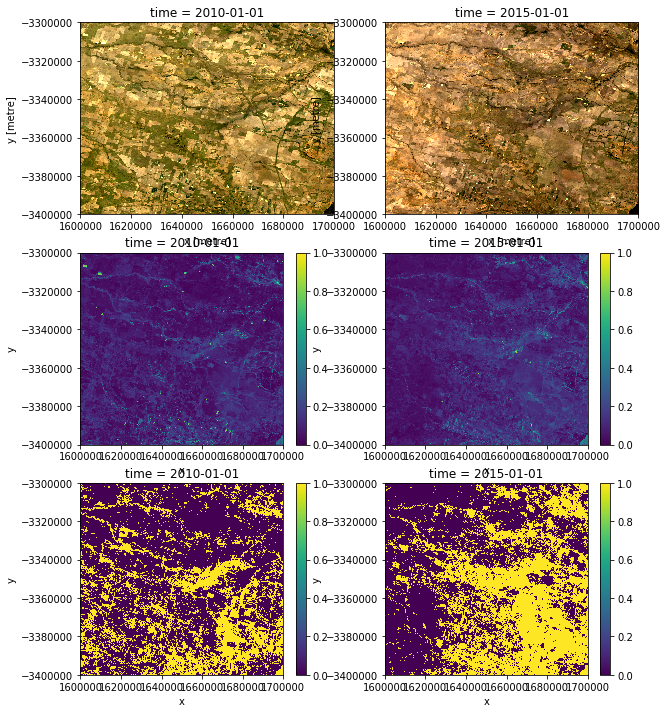

In [28]:
# Set up subplots
f, ax = plt.subplots(3, 2, figsize=(10,12), squeeze=False)

# 2010 images
rgb(i_2010, bands=['red','green','blue'], ax=ax[0,0])
wcf_2010.plot(ax=ax[1,0],vmin=0,vmax=1)
(wcf_2010>0.1).plot(ax=ax[2,0],vmin=0,vmax=1)

# 2015 images
rgb(i_2015, bands=['red','green','blue'], ax=ax[0,1])
wcf_2015.plot(ax=ax[1,1],vmin=0,vmax=1)
(wcf_2015>0.1).plot(ax=ax[2,1],vmin=0,vmax=1)

### Save results to Geotiff
To save results to geotiff for use and analysis in GIS software packages un comment the following Write_geotiff comands.

In [220]:
# Turn DataArrays into a Xarray Datasets for export to geotiff

# 2015
dataset = wcf_2015.to_dataset(name='wcf_2015').assign_attrs({'crs': 'EPSG:3577'})
write_geotiff('WCF_'+location+'_2015.tif', dataset)

write_geotiff('RGB_'+location+'_2015.tif', i_2015.isel(time=0))

# 2010
dataset = wcf_2010.to_dataset(name='wcf_2010').assign_attrs({'crs': 'EPSG:3577'})
write_geotiff('WCF_'+location+'_2010.tif', dataset)

write_geotiff('RGB_'+location+'_2010.tif', i_2010.isel(time=0))

In [1]:
i_2010

NameError: name 'i_2010' is not defined

### Useful but removed

In [8]:
image = i_2015

In [9]:
image

<xarray.Dataset>
Dimensions:  (time: 1, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 -3.4e+06 -3.4e+06 -3.4e+06 ... -3.3e+06 -3.3e+06
  * x        (x) float64 1.7e+06 1.7e+06 1.7e+06 ... 1.6e+06 1.6e+06 1.6e+06
Data variables:
    blue     (time, y, x) int16 334 297 311 333 329 ... 1053 1022 966 996 1028
    green    (time, y, x) int16 481 437 458 486 473 ... 1354 1312 1224 1263 1308
    red      (time, y, x) int16 504 430 473 516 493 ... 1650 1597 1481 1531 1582
    nir      (time, y, x) int16 1823 1808 1863 1976 1846 ... 2155 1992 2072 2134
    swir1    (time, y, x) int16 1749 1548 1630 1729 1653 ... 2938 2660 2821 2862
    swir2    (time, y, x) int16 1026 885 945 988 959 ... 2675 2397 2560 2583
Attributes:
    crs:      EPSG:3577

In [29]:
# Prepare dataset to go in the model
flat = sklearn_flatten(image)
flat = flat/10000

# Run to model
results = improved_grid_model.predict(flat)

# Unflatten the results
unflat = (sklearn_unflatten(results,image).transpose())[0]

unflat

<xarray.DataArray (y: 10000, x: 10000)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00729598, 0.00729598, 0.00703651, ..., 0.09280083, 0.09280083,
        0.09280083],
       [0.00729598, 0.00729598, 0.00703651, ..., 0.09280083, 0.09280083,
        0.09280083],
       [0.00729598, 0.00729598, 0.00703651, ..., 0.09280083, 0.09280083,
        0.09280083]])
Coordinates:
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 ... 1.6e+06 1.6e+06 1.6e+06
  * y        (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 ... -2.2e+06 -2.2e+06
    time     datetime64[ns] 2015-01-01

(array([47992539.,   179312.,   156528.,   188315.,   132816.,   131138.,
          167763.,   196150.,   194398.,   210361.,   303524.,   377234.,
          360316.,   312306.,   291551.,   309035.,   327997.,   326855.,
          319047.,   315048.,   313973.,   315020.,   306944.,   303386.,
          301179.,   290686.,   278511.,   272467.,   267186.,   268620.,
          255041.,   244765.,   242127.,   227015.,   229665.,   255111.,
          274857.,   235687.,   200373.,   191606.,   183184.,   174216.,
          169877.,   163631.,   155697.,   153132.,   148410.,   141559.,
          137094.,   132197.,   127864.,   127043.,   128459.,   132193.,
          132857.,   138548.,   134544.,   133386.,   130371.,   131923.,
          134210.,   132199.,   128708.,   126040.,   123243.,   123728.,
          120876.,   119950.,   114166.,   114239.,   112390.,   112946.,
          113419.,   117578.,   118983.,   120714.,   117410.,   116176.,
          116685.,   117466.,   118242

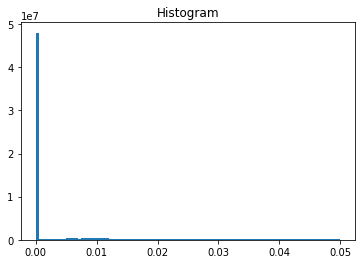

In [34]:
xr.plot.hist(unflat,bins=100,range=(0,0.05))

#### Apply a threshold

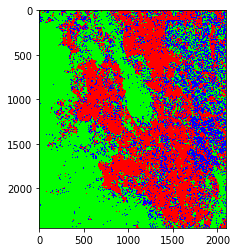

In [41]:
not_woody = unflat<=0.1
woody = np.logical_and(unflat>0.1,unflat<=0.2)
very_woody = unflat>0.2

#We use this numpy function to stack 2-dimensional arrays over the 3rd axis or depth:
classes= np.dstack((not_woody,very_woody,woody)).astype(np.uint8) * 255

plt.imshow(classes)

In [42]:
# Constants for calculating burnt area
resolution = (-30,30)
pixel_length = resolution[1] # in metres
#print(pixel_length)
m_per_km = 1000 # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length**2/m_per_km**2
#print(area_per_pixel)

# Calculate areas
not_woody_area = np.sum(not_woody.values)*area_per_pixel
woody_area = np.sum(woody.values)*area_per_pixel
very_woody_area = np.sum(very_woody.values)*area_per_pixel

print('Not woody:  ',not_woody_area)
print('Woody:      ',woody_area)
print('Very woody: ',very_woody_area)

Not woody:   1648.9188
Woody:       874.3446
Very woody:  2080.4994


In [43]:
# Mask
masked = baseline_da.where(unflat>0.1)
rgb(masked, bands=['red', 'green', 'blue'],size=10)

# Visualise median image as true colour image
rgb(baseline_da, bands=['red', 'green', 'blue'],size=10)

NameError: name 'baseline_da' is not defined

### Burn areas

In [33]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

## Select Location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [1]:
# Set the central latitude and longitude
central_lat = -36.72 
central_lon = 149.95

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
lats = (central_lat - buffer, central_lat + buffer)
lons = (central_lon - buffer, central_lon + buffer)

#display_map(x=lons, y=lats, margin=-0.2)

In [30]:
#list(dc.list_products()['name'])

In [34]:
fire_date = '2018-03-18'
time_step = timedelta(days=120)

# Calculate the start and end date for baseline data load
start_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-timedelta(days=1)), '%Y-%m-%d')

# Calculate end date for post fire data load
start_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=1)), '%Y-%m-%d')
end_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=15)), '%Y-%m-%d')

# Print dates
print('start_date_pre:  '+start_date_pre)
print('end_date_pre:    '+end_date_pre) # if end date is exclusive, just use fire_date
print('fire_date:       '+fire_date)
print('start_date_post: '+start_date_post)
print('end_date_post:   '+end_date_post)

start_date_pre:  2017-11-18
end_date_pre:    2018-03-17
fire_date:       2018-03-18
start_date_post: 2018-03-19
end_date_post:   2018-04-02


In [35]:
products = ['ga_ls8c_ard_3']
measurements = ['nbar_blue','nbar_green','nbar_red','nbar_nir', 'nbar_swir_1', 'nbar_swir_2']
resolution=(-30, 30)

### Before

In [36]:
# Load all data before fire
before =  load_ard(dc=dc,
                   products=products,
                   x=lons,
                   y=lats,
                   time=(start_date_pre, end_date_pre),
                   measurements=measurements,
                   min_gooddata=0.5,
                   output_crs='EPSG:3577',
                   resolution=resolution
            #      dask_bs = {'x': 500, 'y': 500},
            #      group_by='solar_day'
                   )


Loading ga_ls8c_ard_3 data
    Filtering to 8 out of 30 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 8 observations 


In [37]:
before

<xarray.Dataset>
Dimensions:      (time: 8, x: 695, y: 815)
Coordinates:
  * x            (x) float64 1.592e+06 1.592e+06 ... 1.612e+06 1.612e+06
  * y            (y) float64 -4.114e+06 -4.114e+06 ... -4.138e+06 -4.138e+06
  * time         (time) datetime64[ns] 2017-11-23T23:50:53.251767 ... 2018-03-08T23:44:32.709683
Data variables:
    nbar_blue    (time, y, x) float32 364.0 430.0 437.0 ... 391.0 365.0 336.0
    nbar_green   (time, y, x) float32 615.0 717.0 740.0 ... 240.0 214.0 190.0
    nbar_red     (time, y, x) float32 520.0 654.0 626.0 ... 172.0 153.0 139.0
    nbar_nir     (time, y, x) float32 2715.0 2960.0 3185.0 ... 150.0 147.0 129.0
    nbar_swir_1  (time, y, x) float32 2077.0 2513.0 2572.0 ... 138.0 110.0 100.0
    nbar_swir_2  (time, y, x) float32 1139.0 1437.0 1355.0 ... 149.0 121.0 103.0
Attributes:
    crs:      EPSG:3577

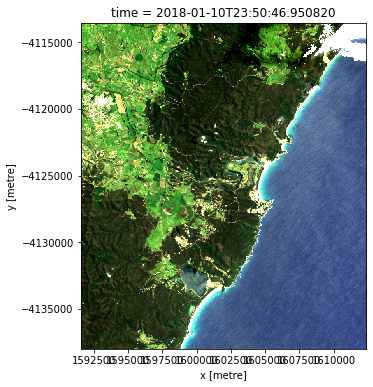

In [38]:
# Visualise before image as  true colour image
rgb(before.isel(time=4), bands=['nbar_red', 'nbar_green', 'nbar_blue']) # 10-01-2018

In [39]:
before_im = before.isel(time=4)

### After

In [40]:
start_date_post, end_date_post

('2018-03-19', '2018-04-02')

In [41]:
# Load all data before fire
after =  load_ard(dc=dc,
                  products=products,
                  x=lons,
                  y=lats,
                  time=(start_date_post, '2018-06-01'),
                  measurements=measurements,
                  min_gooddata=0.5,
                  output_crs='EPSG:3577',
                  resolution=resolution
            #     dask_bs = {'x': 500, 'y': 500},
            #     group_by='solar_day'
                  )


Loading ga_ls8c_ard_3 data
    Filtering to 5 out of 18 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 5 observations 


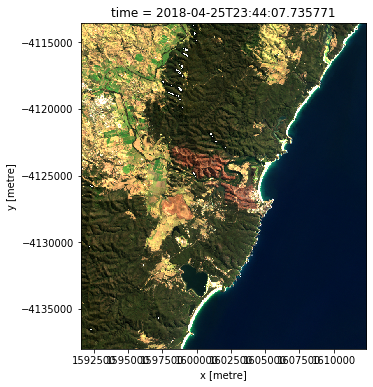

In [42]:
# Visualise after image as  true colour image
rgb(after.isel(time=2), bands=['nbar_red', 'nbar_green', 'nbar_blue']) # 2 is good, 4? 5 best! (25-04-2018)

In [43]:
after_im = after.isel(time=2)
after_im

<xarray.Dataset>
Dimensions:      (x: 695, y: 815)
Coordinates:
  * x            (x) float64 1.592e+06 1.592e+06 ... 1.612e+06 1.612e+06
  * y            (y) float64 -4.114e+06 -4.114e+06 ... -4.138e+06 -4.138e+06
    time         datetime64[ns] 2018-04-25T23:44:07.735771
Data variables:
    nbar_blue    (y, x) float32 307.0 374.0 447.0 381.0 ... 281.0 283.0 277.0
    nbar_green   (y, x) float32 425.0 556.0 674.0 569.0 ... 172.0 175.0 169.0
    nbar_red     (y, x) float32 505.0 571.0 939.0 763.0 ... 96.0 94.0 105.0 99.0
    nbar_nir     (y, x) float32 1909.0 2301.0 2445.0 2400.0 ... 55.0 55.0 56.0
    nbar_swir_1  (y, x) float32 1574.0 1815.0 2985.0 2371.0 ... 28.0 31.0 26.0
    nbar_swir_2  (y, x) float32 737.0 1008.0 1585.0 1231.0 ... 24.0 25.0 25.0
Attributes:
    crs:      EPSG:3577

### Remove NANs

### Get model

In [77]:
# pickle_in = open('../Gabrielle/pickled.pickle','rb')
# model = pickle.load(pickle_in)
# print(model)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=50,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)


### Predict WCF on image

Define a function to format image and run model over it

In [92]:
# def predict_wcf(image,model):
#     flat = sklearn_flatten(image)
#     flat = flat/10000
#     results = model.predict(flat)
#     unflat = (sklearn_unflatten(results,image).transpose())[0]
#     return unflat

In [47]:
wcf_before = predict_wcf(before_im,model)
wcf_after = predict_wcf(after_im,model)

In [48]:
before_im

<xarray.Dataset>
Dimensions:      (x: 695, y: 815)
Coordinates:
  * x            (x) float64 1.592e+06 1.592e+06 ... 1.612e+06 1.612e+06
  * y            (y) float64 -4.114e+06 -4.114e+06 ... -4.138e+06 -4.138e+06
    time         datetime64[ns] 2018-01-10T23:50:46.950820
Data variables:
    nbar_blue    (y, x) float32 329.0 358.0 364.0 315.0 ... 598.0 598.0 600.0
    nbar_green   (y, x) float32 600.0 678.0 688.0 497.0 ... 428.0 434.0 435.0
    nbar_red     (y, x) float32 474.0 514.0 503.0 414.0 ... 369.0 377.0 379.0
    nbar_nir     (y, x) float32 2799.0 3098.0 3611.0 ... 375.0 382.0 379.0
    nbar_swir_1  (y, x) float32 2112.0 2322.0 2210.0 ... 300.0 313.0 307.0
    nbar_swir_2  (y, x) float32 949.0 1130.0 994.0 785.0 ... 257.0 266.0 261.0
Attributes:
    crs:      EPSG:3577

### Plot the results

Woody cover in training data varies between 0 and 1

In [49]:
wcf_before

<xarray.DataArray (x: 695)>
array([0.2700182 , 0.08154426, 0.07162472, 0.38615262, 0.48906672,
       0.38125277, 0.1309374 , 0.50903555, 0.04187032, 0.01051532,
       0.01283862, 0.03168861, 0.03264563, 0.02817224, 0.03297697,
       0.03857609, 0.03149406, 0.02946526, 0.00998909, 0.0157258 ,
       0.03131759, 0.30446357, 0.30446357, 0.46480504, 0.27049197,
       0.43484877, 0.91480316, 0.85796123, 0.37406709, 0.35806323,
       0.5385765 , 0.72180959, 0.91357587, 0.44642837, 0.13825885,
       0.13280455, 0.30791856, 0.35895056, 0.43525372, 0.28022156,
       0.14723507, 0.28480661, 0.30315398, 0.04972784, 0.04067788,
       0.03027955, 0.02708935, 0.02308904, 0.02977094, 0.01580448,
       0.0108883 , 0.03273823, 0.04372424, 0.01092026, 0.05108447,
       0.1102238 , 0.09761103, 0.03412277, 0.02664199, 0.02170109,
       0.02893779, 0.12955907, 0.33327604, 0.16232591, 0.16606974,
       0.12414661, 0.07271433, 0.03337044, 0.08686158, 0.11581827,
       0.10832734, 0.19824829, 0.48453449, 0.16284767, 0.15282957,
       0.13819051, 0.13661162, 0.1353194 , 0.17079386, 0.50218574,
       0.34191659, 0.06049792, 0.31142016, 0.32912787, 0.29394375,
       0.06338301, 0.03227461, 0.07271433, 0.07061678, 0.02921324,
       0.01447638, 0.02042988, 0.0255453 , 0.00715415, 0.00941105,
       0.01032522, 0.00699841, 0.02192354, 0.01953153, 0.06740486,
       0.04577744, 0.06027785, 0.03552147, 0.08576492, 0.08326933,
       0.13272662, 0.12070402, 0.26970356, 0.16929613, 0.21225027,
       0.27294635, 0.26695931, 0.26869559, 0.27672799, 0.26539795,
       0.30796211, 0.89364428, 0.83896052, 0.82182555, 0.6809767 ,
       0.46793763, 0.27898231, 0.14999498, 0.13167769, 0.14368887,
       0.31417111, 0.40265035, 0.13339163, 0.10181196, 0.09409728,
       0.08182094, 0.0346218 , 0.02872959, 0.28106874, 0.34097064,
       0.14149848, 0.14266704, 0.13280455, 0.13533312, 0.08362557,
       0.08844783, 0.10995113, 0.35650811, 0.35304752, 0.42212966,
       0.09047931, 0.28127526, 0.09254912, 0.58525559, 0.93555496,
       0.87719539, 0.45454096, 0.42288439, 0.45162223, 0.31871176,
       0.03468625, 0.03340055, 0.03340055, 0.03692704, 0.05862699,
       0.03546659, 0.02664199, 0.01857391, 0.01045243, 0.04936744,
       0.06885178, 0.12256743, 0.06780363, 0.02063463, 0.08826776,
       0.19142856, 0.12955907, 0.12601376, 0.501102  , 0.46142098,
       0.16997576, 0.2744154 , 0.10850682, 0.27723488, 0.09178153,
       0.02830287, 0.33799812, 0.29855347, 0.13280455, 0.18321736,
       0.12955997, 0.08229428, 0.02757768, 0.02387057, 0.02290616,
       0.09366093, 0.08919098, 0.11263979, 0.13043892, 0.26491682,
       0.12433343, 0.07987984, 0.06286541, 0.08179969, 0.08749265,
       0.05573284, 0.03261282, 0.01684101, 0.00985449, 0.00975117,
       0.01122342, 0.02195931, 0.0298365 , 0.26788427, 0.76061019,
       0.20046785, 0.21330512, 0.6705322 , 0.82472059, 0.37397512,
       0.0789314 , 0.02664199, 0.03448284, 0.06276311, 0.28786591,
       0.10973501, 0.07817947, 0.12008828, 0.24140569, 0.08568915,
       0.08332668, 0.08873816, 0.1419021 , 0.70633623, 0.29438479,
       0.06009656, 0.04826782, 0.07819064, 0.07537371, 0.056843  ,
       0.08323474, 0.02063249, 0.32411147, 0.86895589, 0.64246268,
       0.22069957, 0.4524876 , 0.6726397 , 0.61070558, 0.08937019,
       0.01377369, 0.03075517, 0.02867636, 0.0295305 , 0.02943672,
       0.02309305, 0.09832899, 0.64800008, 0.91561014, 0.90579432,
       0.88215455, 0.91544365, 0.92119087, 0.85673473, 0.88784793,
       0.87233033, 0.86336232, 0.80051542, 0.84925279, 0.77535752,
       0.84747997, 0.8712951 , 0.85844107, 0.93287183, 0.93229434,
       0.90151064, 0.90736555, 0.77595143, 0.85250793, 0.85517298,
       0.87733234, 0.81677382, 0.82509693, 0.88729396, 0.88962291,
       0.89283256, 0.67100703, 0.90877708, 0.83122837, 0.87743766,
       0.85304485, 0.9046514 , 0.84574316, 0.34700835, 0.43300573,
       0.5944961 , 0.63742206, 0.71223641, 0.89592489, 0.60229442,
       0.2898269 , 

Exception: The input dataset `ds` has more than two dimensions: {list(ds.dims.keys())}. Please select a single observation using e.g. `index=0`, or enable faceted plotting by adding the arguments e.g. `col="time", col_wrap=4` to the function call

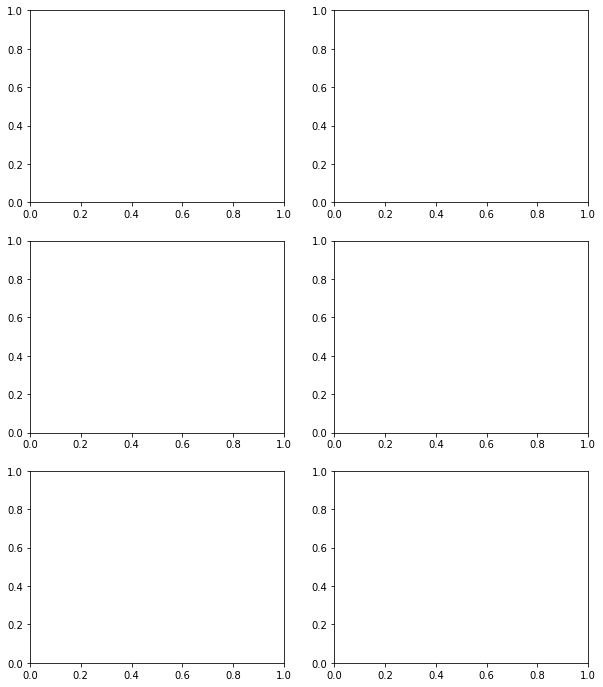

In [50]:
# Set up subplots
f, ax = plt.subplots(3, 2, figsize=(10,12), squeeze=False)

# before images
rgb(before, bands=['nbar_red', 'nbar_green', 'nbar_blue'], ax=ax[0,0])
wcf_before.plot(ax=ax[1,0],vmin=0,vmax=1)
(wcf_before>0.1).plot(ax=ax[2,0],vmin=0,vmax=1)

# after images
rgb(after, bands=['nbar_red', 'nbar_green', 'nbar_blue'], ax=ax[0,1])
wcf_after.plot(ax=ax[1,1],vmin=0,vmax=1)
(wcf_after>0.1).plot(ax=ax[2,1],vmin=0,vmax=1)